In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from package_global_functions import *

In [2]:
def ode_rho_m(t,rhom,pi,l1,l2,gamma):
    '''
    ODEs with the full set of parameters: pi, l1,l2 for linear and quadratic recruitment, gamma for cross-inhibition
    mind that these parameters are actually rescaled by r, and we integrate in the rescaled time tau = t*r
    '''
    rho, m = rhom
    drho_dtau = (1-rho)*(2*pi + l1*rho + l2/2 * (rho**2 + m**2)) - rho - gamma/2*(rho**2 - m**2)
    dm_dtau = m * ((1-rho)*(l1+l2*rho) - 1)
    return [drho_dtau,dm_dtau]

def rho_m_teo(pi,l1,l2,gamma):
    if l2 < 1e-8 and l1 > 0.0 and gamma > 0.0: # CI model; no l2
        rho = 1 - 1/l1
    else: # gamma = 0 or l1 = 0 will work fine with the general formula
        rho = 0.5 * (1-l1/l2 + 1/l2 * np.sqrt((l1+l2)**2 - 4*l2))
    m = np.sqrt(rho**2 - 4*pi/(l2 + gamma/(1-rho)))
    return (rho, m)

In [10]:
# rhom0 = (1.0, 0.01)
rhom0 = (0.1, 0.09)

# combinations of parameters that yield very similar m* in both models
pi = 0.01
l1 = 1.5
other_interaction = 0.35
# another one:
pi = 0.2
l1 = 2.0
other_interaction = 1.78

# prova especifica:
pi, l1, other_interaction = 0.1, 1.5, 1.32

maxTime = 3000

# HOI
l2, gamma = other_interaction, 0.0
sol_hoi = solve_ivp(ode_rho_m, [0, 1e4], rhom0, args=(pi, l1, l2, gamma))
rhom_teo_hoi = rho_m_teo(pi, l1, l2, gamma)
# tss_hoi = evoTimeDeriv_solve_ivp(sol_hoi, discard_initial=25.0, thresh=8e-5)
tss_hoi, evoDeriv = evoTimeDeriv_general(sol_hoi.t[sol_hoi.t > 50.0], sol_hoi.y[1][sol_hoi.t > 50.0], getFullEvo=True, thresh=5e-5)

# CI
l2, gamma = 0.0, other_interaction
sol_ci = solve_ivp(ode_rho_m, [0, maxTime], rhom0, args=(pi, l1, l2, gamma))
rhom_teo_ci = rho_m_teo(pi, l1, l2, gamma)
tss_ci = evoTimeDeriv_solve_ivp(sol_ci, discard_initial=25.0, thresh=1e-4)
print('ms ', rhom_teo_hoi[1], rhom_teo_ci[1])
print('tss ', tss_hoi, tss_ci)

ms  0.024812290877105507 nan
tss  421.98999794823783 64.15012568418334


/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_12805/2533108940.py:16: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt(rho**2 - 4*pi/(l2 + gamma/(1-rho)))


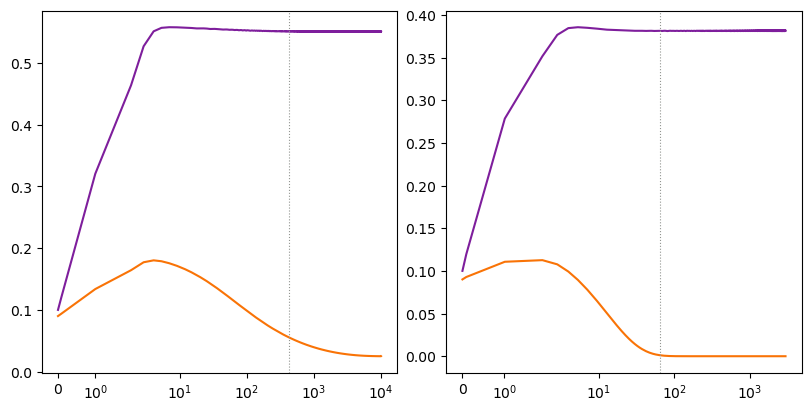

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
ax[0].set(xscale='symlog')
ax[1].set(xscale='symlog')

ax[0].plot(sol_hoi.t, sol_hoi.y[0], color='xkcd:purple')
ax[0].plot(sol_hoi.t, sol_hoi.y[1], color='xkcd:orange')
# ax[0].axhline(rhom_teo_hoi[1], color='xkcd:orange', ls='--', lw=0.8)
ax[0].axvline(tss_hoi, color='xkcd:gray', ls=':', lw=0.8)

ax[1].plot(sol_ci.t, sol_ci.y[0], color='xkcd:purple')
ax[1].plot(sol_ci.t, sol_ci.y[1], color='xkcd:orange')
# ax[1].axhline(rhom_teo_ci[1], color='xkcd:orange', ls='--', lw=0.8)
ax[1].axvline(tss_ci, color='xkcd:gray', ls=':', lw=0.8)

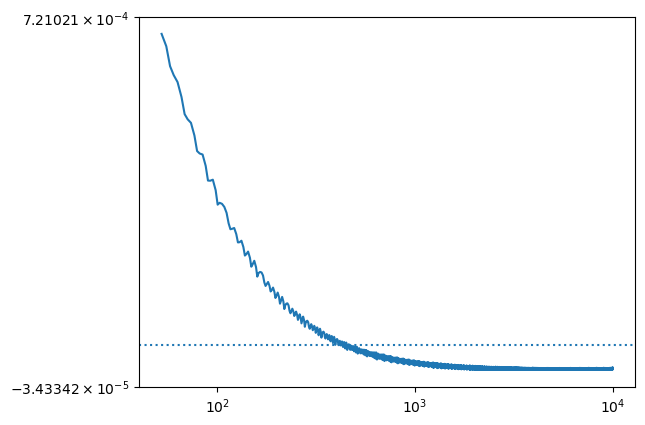

In [12]:
fig, ax = plt.subplots(1, 1)
ax.set(yscale='symlog', xscale='symlog')
ax.axhline(5e-5, ls=':')
ax.plot(sol_hoi.t[sol_hoi.t > 50.0], abs(evoDeriv))

In [9]:
# some initial condition equal for all
rhom0 = (0.1, 0.01)

l1 = 1.5
pis = [0.0, 0.01, 0.1, 0.2]
discard_inTime = {0.0:50, 0.01:50.0, 0.1:25.0, 0.2:25.0}

intParamRange = np.arange(0.05, 5.0, 0.05) # value of l2 or gamma, depending on the model, and while the other is 0.0
intParamRange = np.concat(np.array([0.001,]), intParamRange)
intMaxTime = 1000

dataInt = {'hoi':{}, 'ci':{}}
for pi in pis:
    dataInt['hoi'][pi] = {'m':[], 'tss':[]}
    dataInt['ci'][pi] = {'m':[], 'tss':[]}
    for intParam in intParamRange:
        sol_hoi = solve_ivp(ode_rho_m, [0, intMaxTime], rhom0, args=(pi, l1, intParam, 0.0))
        sol_ci = solve_ivp(ode_rho_m, [0, intMaxTime], rhom0, args=(pi, l1, 0.0, intParam))
        tss_hoi = evoTimeDeriv(sol_hoi, discard_initial=50.0)
        tss_ci = evoTimeDeriv(sol_ci, discard_initial=50.0)
        for k,(m,tss) in zip(['hoi', 'ci'], [(sol_hoi.y[1][-1], tss_hoi), (sol_ci.y[1][-1], tss_ci)]):
            dataInt[k][pi]['m'].append(m), dataInt[k][pi]['tss'].append(tss)

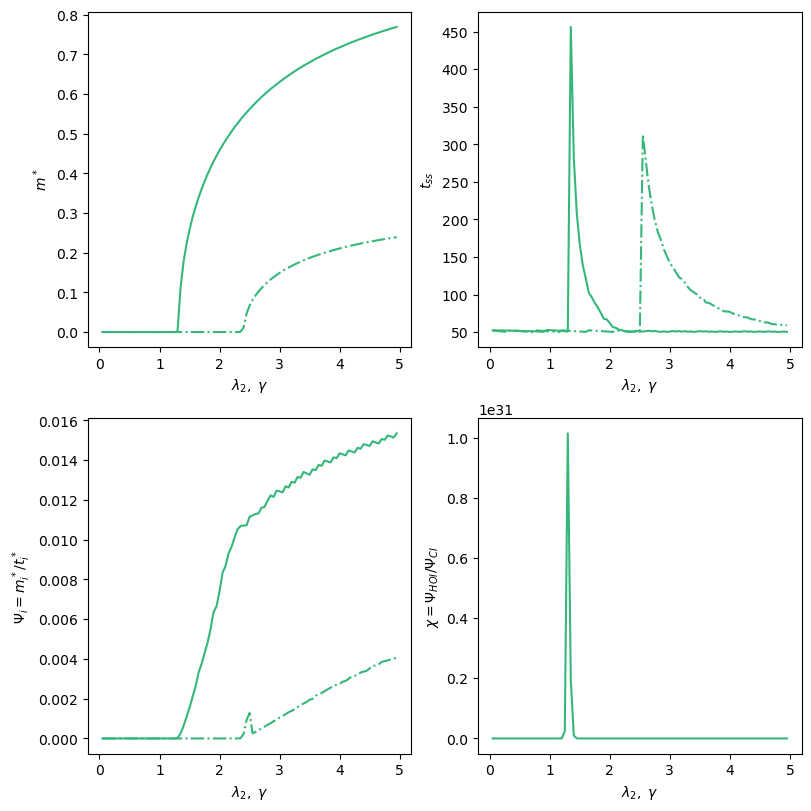

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(8,8), constrained_layout=True)

ylabels = [[r'$m^*$', r'$t_{ss}$'], [r'$\Psi_i = m^*_i / t^*_i$', r'$\chi = \Psi_{HOI} / \Psi_{CI}$']]
for i in range(2):
    for j in range(2):
        ax[i,j].set(xlabel=r'$\lambda_2, \; \gamma$', ylabel=ylabels[i][j])

pi = 0.1
pi_colors = plt.cm.viridis(np.linspace(0,1,len(pis)))
c = pi_colors[pis.index(pi)]

ms_hoi, ms_ci =  np.array(dataInt['hoi'][pi]['m'][1:]), np.array(dataInt['ci'][pi]['m'][1:])
tss_hoi, tss_ci = np.array(dataInt['hoi'][pi]['tss'][1:]), np.array(dataInt['ci'][pi]['tss'][1:])


ax[0,0].plot(intParamRange[1:], ms_hoi, ls='-', color=c)
ax[0,0].plot(intParamRange[1:], ms_ci, ls='-.', color=c)

ax[0,1].plot(intParamRange[1:], tss_hoi, ls='-', color=c)
ax[0,1].plot(intParamRange[1:], tss_ci, ls='-.', color=c)

psi_hoi, psi_ci = ms_hoi/tss_hoi, ms_ci/tss_ci
ax[1,0].plot(intParamRange[1:], psi_hoi, ls='-', color=c)
ax[1,0].plot(intParamRange[1:], psi_ci, ls='-.', color=c)

ax[1,1].plot(intParamRange[1:], psi_hoi/psi_ci, color=c)



In [18]:
ylabels = [[r'$m^*$', r'$t_{ss}$'], [r'$\Psi_i = m^*_i / t^*_i$', r'$\chi = \Psi_{HOI} / \Psi_{CI}$']]

In [20]:
ylabels[0][1]

'$t_{ss}$'

In [26]:
1.193407**2

1.4242205063304099